# 神经网络的学习

## 从数据中学习

数据分类：

* 训练数据

* 测试数据

为了正确评价模型的**泛化能力**就必须分为训练数据（监督数据）和测试数据。

泛化能力：处理未被观察过的数据的能力。

过拟合：对某个数据集过度拟合的状态。

## 损失函数

损失函数：表示网络的性能的“恶劣程度”的指标。

一般采用均方误差和交叉熵误差。

### 均方误差

$$
E = \frac{1}{2} \sum_{k}(y_k - t_k)^2
$$

$y_k$表示神经网络的输出，$t_k$表示监督数据，$k$表示数据的维数。

In [1]:
import numpy as np

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

### 交叉熵误差

$$
E = - \sum_{k} t_k \log y_k
$$

In [2]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return - np.sum(t * np.log(y + delta)) # delta是为了防止输出-inf

### mini-batch 学习

神经网络的学习一般从训练数据中选出一批数据（称为mini-batch），然后对每个mini-batch进行学习。目的是减少计算过程。

In [3]:
import os, sys
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train) , (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [4]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [5]:
def cross_entropy_error(y, t):
    if y.dim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) /batch_size

## 数值微分

导数：

$$
\frac{df(x)}{dx} = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}
$$

In [6]:
# 不好的实现实例
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

中心差分的实现：

In [7]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

## 梯度

所有的偏导数汇总而成的向量称为**梯度**。

In [8]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)

    return grad

机器学习的主要任务是在学习时寻找最优参数。同样，神经网络也必须在学习时找到最优的参数。这里的最优参数即损失函数取最小值时的参数。

用来寻找函数最小值的一个办法之一就是梯度法，在梯度法中，函数的取值从当前位置沿着梯度的方向前进一定距离，然后重新求梯度，然后再沿着新梯度的方向前进，如此反复即可。

$$
x_0 = x_0 - \eta \frac{\partial f}{\partial x_0} \\
x_1 = x_1 - \eta \frac{\partial f}{\partial x_1}
$$

$\eta$表示更新量，称为学习率。

In [9]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

学习率属于超参数，不能通过训练得到，必须尝试多个值。

神经网络的学习也要求梯度，假设权重$W$为：

$$
W = \left ( \begin{matrix}
  w_{11}&  w_{12}& w_{13}\\
  w_{21}&  w_{22}& w_{23}
\end{matrix} \right ) 
$$

则其梯度：

$$
\frac{\partial L}{\partial W} = \left ( \begin{matrix}
  \frac{\partial L}{\partial w_{11}} &  \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}}\\
  \frac{\partial L}{\partial w_{21}} &  \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}}\end{matrix} \right ) 
$$

In [10]:
import os, sys
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [11]:
net = simpleNet()
print(net.W)
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print(np.argmax(p))
t = np.array([0, 0, 1])
print(net.loss(x, t))

[[0.39558669 0.04172507 0.35727367]
 [0.92844879 1.18878726 1.95050739]]
[1.07295592 1.09494357 1.96982085]
2
0.6014479976487553


## 学习算法的实现

神经网络的学习步骤：

1. mini-batch：从训练数据中随机选出一部分数据进行训练

2. 计算梯度

3. 更新参数

4. 重复步骤1~3

In [12]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hiden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hiden_size)
        self.params['b1'] = np.zeros(hiden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hiden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradients(self, x, t):
        loss_w = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_w, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_w, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_w, self.params['b2'])

        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

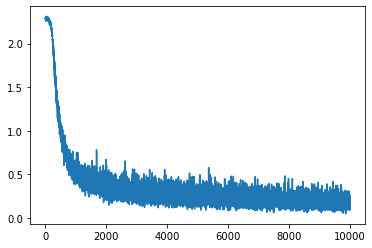

In [13]:
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
network = TwoLayerNet(input_size=784, hiden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # gead = network.numerical_gradients(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

import matplotlib.pyplot as plt

plt.plot(list(range(iters_num)), train_loss_list)
plt.show()

基于测试数据的评价

train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.78605, 0.7929
train acc, test acc | 0.8775, 0.8819
train acc, test acc | 0.9003666666666666, 0.9035
train acc, test acc | 0.9091333333333333, 0.913
train acc, test acc | 0.91665, 0.9196
train acc, test acc | 0.9217166666666666, 0.9235
train acc, test acc | 0.9261, 0.9288
train acc, test acc | 0.9302333333333334, 0.9321
train acc, test acc | 0.9329, 0.9339
train acc, test acc | 0.9366, 0.9373
train acc, test acc | 0.93795, 0.9374
train acc, test acc | 0.9408166666666666, 0.9408
train acc, test acc | 0.9428166666666666, 0.9425
train acc, test acc | 0.9454666666666667, 0.9445
train acc, test acc | 0.9461166666666667, 0.9453
train acc, test acc | 0.9474833333333333, 0.9469


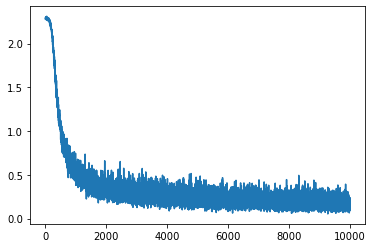

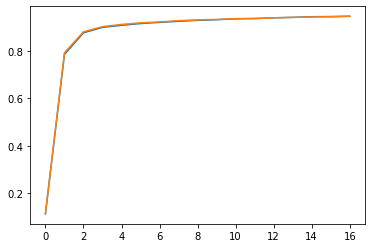

In [16]:
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hiden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # gead = network.numerical_gradients(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i %  iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

import matplotlib.pyplot as plt

plt.plot(list(range(iters_num)), train_loss_list)
plt.show()
plt.plot(list(range(len(train_acc_list))), train_acc_list)
plt.plot(list(range(len(test_acc_list))), test_acc_list)
plt.show()